In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import pickle

In [3]:
result_explanations_dir = './results_explanations'

explanation_eval_dir = f'{result_explanations_dir}/X_BATCH_results_eval_explanations'
explanation_gen_dir = f'{result_explanations_dir}/X_BATCH_output_explanations'
explanation_gen_discrete_dir = f'{result_explanations_dir}/X_BATCH_explanations_discrete_batching'

model_name = 'second_level_train_last'
model_par = '4_2_5e_05'

considered_combinations = [ ('perc', 100), ('perc', 50), ('perc', 45), ('perc', 40), ('perc', 35), ('perc', 30), ('perc', 25), ('perc', 20)] #,

boosting_combs = [f'_NER{b}' for b in [1, 2, 3, 5, 7, 10, 15, 20, 30]]


coll_res = {}

percentages_mod = {}
percentages_avg_diff = {}

for explainer_name in ['loo', 'gradient', 'gradientXinput']:
    for (k_type, k_value) in considered_combinations:
        for masking in ['none', 'roberta']:
            for boosting in ['']+boosting_combs:
                explainer_name_b = f'{explainer_name}{boosting}'


                filename = f'{explanation_eval_dir}/predictions_{model_name}_mask_{masking}_{model_par}_{explainer_name_b}_{k_type}_{k_value}_result.csv'
                if os.path.isfile(filename):
                    res_df = pd.read_csv(filename, index_col=0)
                    for metric in res_df.index:
                        config = "_".join([explainer_name_b, k_type, str(k_value), masking])
                        if metric not in coll_res:
                            coll_res[metric]={}
                        coll_res[metric][config] = res_df['mean'][metric]

                filename = f'{explanation_gen_discrete_dir}/{masking}/{explainer_name_b}/NERstats_{model_name}_mask_{masking}_{model_par}_{explainer_name_b}.pickle'
                if os.path.isfile(filename):
                    with open(filename, 'rb') as fp:
                        perc_mod = pickle.load(fp)
                        percentages_mod[f'{explainer_name_b}_{masking}'] = {k:list(v['modified'])[0] if v!=None else None for k, v in perc_mod.items() }
                        percentages_avg_diff[f'{explainer_name_b}_{masking}'] = {k:list(v['avg_diff_perc'])[0] if v!=None else None  for k, v in perc_mod.items()}
 

In [4]:
df_res = pd.DataFrame(coll_res)

df_res.to_csv(f'{result_explanations_dir}/plausibility.csv')
df_res1 = df_res.loc[df_res.index.str.contains('perc_40')]
df_res.to_csv(f'{result_explanations_dir}/plausibility_40.csv')

In [5]:
explainers = ['loo', 'gradientXinput', 'gradient']
idxs_40 = [f'{e}_perc_40_none' for e in explainers] + [f'{e}_perc_40_roberta' for e in explainers] + [f'{e}_NER7_perc_40_none' for e in explainers] + [f'{e}_NER7_perc_40_roberta' for e in explainers]
idxs = [idx for idx in  idxs_40 if idx in df_res.index]
display((df_res.loc[idxs]*100).round(2))
(df_res.loc[idxs]*100).round(2).style.highlight_max(color='blue')

,ROUGE-1,ROUGE-2,ROUGE-L,Jaccard,Overmin,Overmax,BLEU,METEOR
loo_perc_40_none,58.33,43.17,56.02,44.54,74.75,52.83,38.22,35.64
gradientXinput_perc_40_none,60.58,45.53,58.17,46.88,76.06,55.21,40.97,37.18
gradient_perc_40_none,62.24,47.76,60.20,48.52,77.31,56.75,43.62,39.18
loo_perc_40_roberta,61.43,46.54,59.19,47.89,76.84,56.05,42.74,38.98
gradientXinput_perc_40_roberta,61.62,47.01,59.51,48.17,77.21,56.33,42.71,38.59
gradient_perc_40_roberta,62.45,48.30,60.61,49.12,77.95,57.14,44.34,39.91
loo_NER7_perc_40_none,58.36,43.20,56.03,44.55,74.75,52.84,38.28,35.66
gradientXinput_NER7_perc_40_none,60.74,45.72,58.33,47.04,76.15,55.38,41.26,37.39
gradient_NER7_perc_40_none,62.82,48.39,60.68,49.16,77.57,57.38,44.99,40.21
gradient_NER7_perc_40_roberta,62.46,48.31,60.62,49.10,77.94,57.12,44.34,39.90


,ROUGE-1,ROUGE-2,ROUGE-L,Jaccard,Overmin,Overmax,BLEU,METEOR
loo_perc_40_none,58.330000,43.170000,56.020000,44.540000,74.750000,52.830000,38.220000,35.640000
gradientXinput_perc_40_none,60.580000,45.530000,58.170000,46.880000,76.060000,55.210000,40.970000,37.180000
gradient_perc_40_none,62.240000,47.760000,60.200000,48.520000,77.310000,56.750000,43.620000,39.180000
loo_perc_40_roberta,61.430000,46.540000,59.190000,47.890000,76.840000,56.050000,42.740000,38.980000
gradientXinput_perc_40_roberta,61.620000,47.010000,59.510000,48.170000,77.210000,56.330000,42.710000,38.590000
gradient_perc_40_roberta,62.450000,48.300000,60.610000,49.120000,77.950000,57.140000,44.340000,39.910000
loo_NER7_perc_40_none,58.360000,43.200000,56.030000,44.550000,74.750000,52.840000,38.280000,35.660000
gradientXinput_NER7_perc_40_none,60.740000,45.720000,58.330000,47.040000,76.150000,55.380000,41.260000,37.390000
gradient_NER7_perc_40_none,62.820000,48.390000,60.680000,49.160000,77.570000,57.380000,44.990000,40.210000
gradient_NER7_perc_40_roberta,62.460000,48.310000,60.620000,49.100000,77.940000,57.120000,44.340000,39.900000


# Random

In [6]:
print('random')
df_random = pd.read_csv(f'{result_explanations_dir}/random_explanation/predictions_random_perc_40_result.csv', index_col=0)
((df_random[['mean']].T)*100).round(2)

random


,ROUGE-1,ROUGE-2,ROUGE-L,Jaccard,Overmin,Overmax,BLEU,METEOR
mean,30.35,19.8,33.98,24.37,68.66,27.97,9.38,16.35


# ILDC 

In [9]:
import json
with open('./Exploration-Lab-CJPE/gold_explanations_ranked.json', 'r') as fp:
    gold_explanations_ranked =  json.load(fp)


import json
with open('./Exploration-Lab-CJPE/occ_explanations_paper_ildc.json', 'r') as fp:
    occ_explanations_paper_ildc =  json.load(fp)

input_data_dir = f'{str(Path.home())}/data/legal'

with open(os.path.join(input_data_dir, 'ILDC_single_entities_roberta_explain_filenames_mapping.csv'), "r") as fp:
        filenames = json.load(fp)

In [8]:
from metricmaker import evaluate_explanation_ILDC_metrics

occ_res = evaluate_explanation_ILDC_metrics(filenames, 1, 10, occ_explanations_paper_ildc, gold_explanations_ranked)

occ_res_df = pd.DataFrame(occ_res).T
occ_res_df['mean'] = occ_res_df.mean(axis=1)

Evaluate for the 5 users..


100%|██████████| 56/56 [00:40<00:00,  1.37it/s]


In [9]:
occ_res_df

,0,1,2,3,4,mean
ROUGE-1,0.444021,0.516734,0.401418,0.390727,0.500831,0.450746
ROUGE-2,0.303267,0.295293,0.296456,0.296485,0.293738,0.297048
ROUGE-L,0.439169,0.407223,0.423051,0.444474,0.407216,0.424227
Jaccard,0.332690,0.316959,0.327895,0.324124,0.317666,0.323867
Overmin,0.744114,0.588710,0.809272,0.833682,0.616897,0.718535
Overmax,0.389719,0.414250,0.359990,0.351068,0.400568,0.383119
BLEU,0.159742,0.279487,0.099217,0.093083,0.248304,0.175966
METEOR,0.210959,0.291842,0.172339,0.169115,0.270302,0.222911


In [10]:
((occ_res_df[['mean']].T)*100).round(2)

,ROUGE-1,ROUGE-2,ROUGE-L,Jaccard,Overmin,Overmax,BLEU,METEOR
mean,45.07,29.7,42.42,32.39,71.85,38.31,17.6,22.29


# User

In [11]:
explainer_b = 'gradient_NER7'
k_value = 40
masking =  'roberta'

df_top2 = pd.read_csv(f'{explanation_eval_dir}/predictions_second_level_train_last_mask_{masking}_4_2_5e_05_{explainer_b}_perc_{k_value}_result.csv', index_col=0)
df_top2 = (df_top2*100).round(2)
df_top2.columns = [f'User {i+1}' for i in range(5) ] + ['avg']
df_top2

,User 1,User 2,User 3,User 4,User 5,avg
ROUGE-1,65.22,60.57,62.98,62.49,61.03,62.46
ROUGE-2,51.70,42.71,51.87,53.40,41.85,48.31
ROUGE-L,63.80,54.97,63.25,66.08,54.99,60.62
Jaccard,53.16,43.58,52.43,53.23,43.10,49.10
Overmin,79.42,71.43,83.67,86.86,68.31,77.94
Overmax,62.01,53.22,58.46,57.90,54.01,57.12
BLEU,48.85,46.20,41.11,39.23,46.31,44.34
METEOR,39.94,47.33,33.97,33.48,44.79,39.90


# Faithfulness

In [12]:
import numpy as np
import os
import pandas as pd
import pickle

In [13]:
faithfulness_result_dir = f'{result_explanations_dir}/X_faithfulness_result'
k_type = 'perc'
k_value = 40
f_res = {}

boosting_combs = [f'_NER{b}' for b in [1, 2, 3, 5, 7, 10, 15, 20, 30]]


for explainer_name in ['loo', 'gradient', 'gradientXinput', 'random']:
    for masking in ['none', 'roberta']:
        for boosting in ['']+boosting_combs:
                for k_value in [40, 35, 30, 25, 20]:
                    explainer_name_b = f'{explainer_name}{boosting}'
                    filename = os.path.join(faithfulness_result_dir, masking, explainer_name_b, f'faithfulness_second_level_train_last_mask_{masking}_4_2_5e_05_{explainer_name_b}_{k_type}_{k_value}.pickle')
                    
                    if os.path.isfile(filename):
                        
                        with open(filename, 'rb') as handle:
                            evaluation_results = pickle.load(handle)
                            config = "_".join([explainer_name_b, k_type, str(k_value), masking])
                            
                            f_res[config] = {k: np.mean(v) for k,v in evaluation_results.items()}


In [14]:
df_faith = pd.DataFrame(f_res).T
faithfulness_metrics = ['compr2', 'suff2']
df_faith = df_faith[faithfulness_metrics]
idxs = ['random_perc_40_none', 'random_perc_40_roberta'] + [idx for idx in  idxs_40 if idx in df_faith.index]
df_faith_sel = df_faith.loc[idxs]
(df_faith_sel).round(3)

,compr2,suff2
random_perc_40_none,0.048,0.296
random_perc_40_roberta,0.035,0.253
loo_perc_40_none,-0.093,0.581
gradientXinput_perc_40_none,0.157,0.120
gradient_perc_40_none,0.142,0.120
loo_perc_40_roberta,-0.102,0.473
gradientXinput_perc_40_roberta,0.218,0.035
gradient_perc_40_roberta,0.190,0.027
loo_NER7_perc_40_none,-0.093,0.581
gradientXinput_NER7_perc_40_none,0.157,0.117


In [15]:
df_faith.loc[idxs].style.highlight_max(color='green')

,compr2,suff2
random_perc_40_none,0.047505,0.295910
random_perc_40_roberta,0.034903,0.253155
loo_perc_40_none,-0.092561,0.581456
gradientXinput_perc_40_none,0.157274,0.119634
gradient_perc_40_none,0.141892,0.119585
loo_perc_40_roberta,-0.101688,0.473315
gradientXinput_perc_40_roberta,0.217690,0.034834
gradient_perc_40_roberta,0.190127,0.026741
loo_NER7_perc_40_none,-0.092718,0.581293
gradientXinput_NER7_perc_40_none,0.156600,0.116748


In [16]:
df_faith.loc[idxs].style.highlight_min(color='yellow')

,compr2,suff2
random_perc_40_none,0.047505,0.295910
random_perc_40_roberta,0.034903,0.253155
loo_perc_40_none,-0.092561,0.581456
gradientXinput_perc_40_none,0.157274,0.119634
gradient_perc_40_none,0.141892,0.119585
loo_perc_40_roberta,-0.101688,0.473315
gradientXinput_perc_40_roberta,0.217690,0.034834
gradient_perc_40_roberta,0.190127,0.026741
loo_NER7_perc_40_none,-0.092718,0.581293
gradientXinput_NER7_perc_40_none,0.156600,0.116748


# Impact boosting 

In [17]:
output_dir = 'figures'
Path(output_dir).mkdir(parents=True, exist_ok=True)

output_dir_separate = f'{output_dir}/separate'
Path(output_dir_separate).mkdir(parents=True, exist_ok=True)

In [18]:
viz_masking = {'none': 'H-UNMASKED', 'roberta': 'H-NER-MASKED'}

## Plausibility

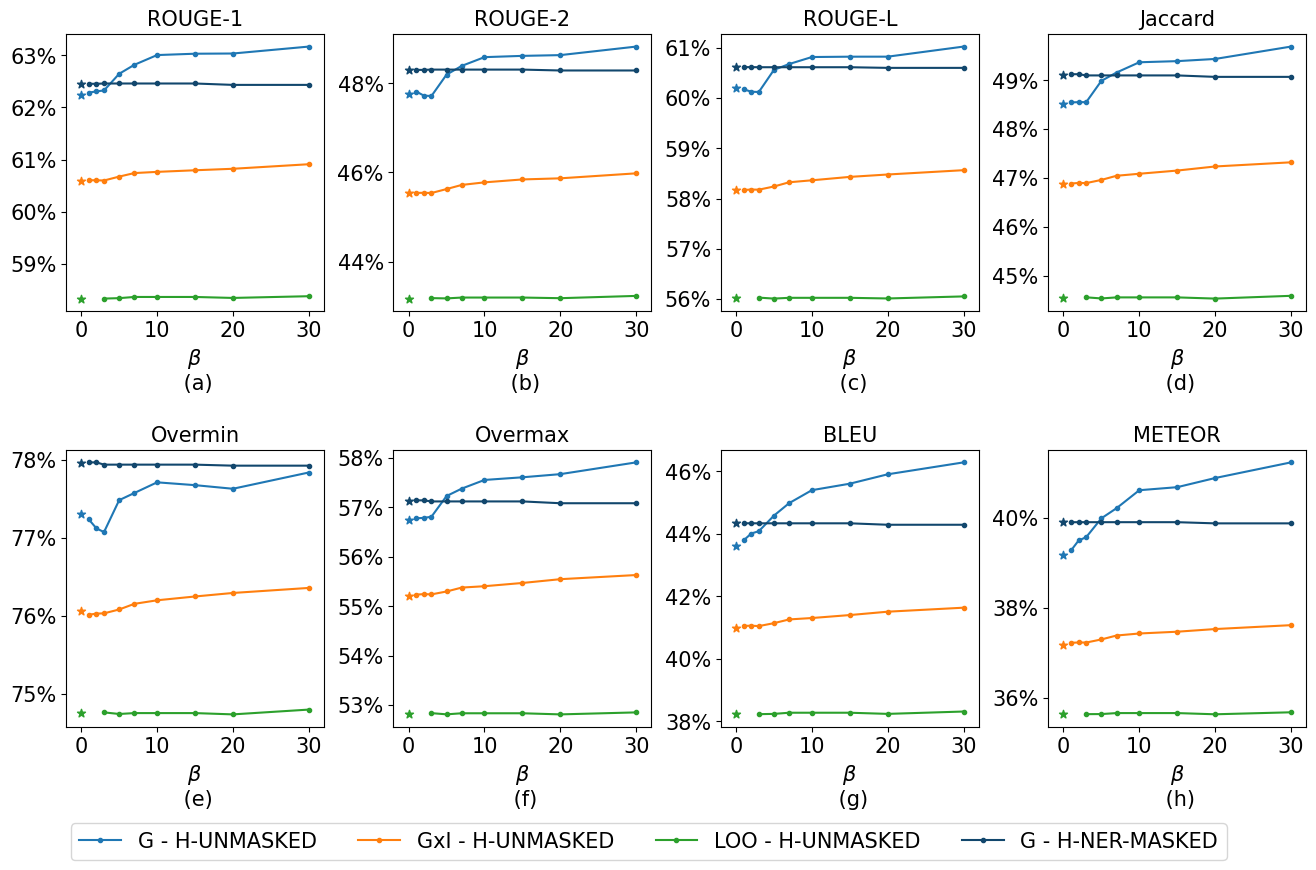

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter


import string
string.ascii_lowercase


df_res = pd.DataFrame(coll_res)
df_res =  df_res.rename(columns={'BLEU   ': 'BLEU', 'METEOR ': 'METEOR'})
df_res_xperc = df_res.loc[(df_res.index.str.contains('perc_40'))]
df_res_ner = df_res_xperc.loc[ (df_res_xperc.index.str.contains('NER')==True)]


pm = pd.DataFrame(percentages_mod).T*100
pm = pm[['perc_40']].dropna()

expl_new_names = {'loo_': 'LOO', 'gradient_': 'G', 'gradientXinput_':'GxI'}
fontsize = 15
minv, maxv = -2, 32


colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c',  '#12476d']

metrics_plot = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Jaccard', 'Overmin', 'Overmax','BLEU', 'METEOR']
fig, (axs) = plt.subplots(2, 4, figsize = (16, 9))

for masking in ['none', 'roberta']:       
    df_res2 = df_res_ner.loc[(df_res_ner.index.str.contains(masking)) ]
    sel1 = pm.loc[pm.index.str.contains(masking)]
    #fig, (axs) = plt.subplots(1, 4, figsize=(15.5,4))

    
    
    for e, explainer in enumerate(['gradient_', 'gradientXinput_', 'loo_']):
        explainer_name = expl_new_names[explainer] + ' - ' + viz_masking[masking]
        df_sel = df_res2.loc[df_res2.index.str.contains(explainer)]
        sel2 = sel1.loc[sel1.index.str.contains(explainer)]

        d_target = df_res_xperc.loc[(df_res_xperc.index.str.contains(explainer))&(df_res_xperc.index.str.contains(masking))&(df_res_xperc.index.str.contains('NER')==False)]*100
        unboosted_metrics = d_target.reset_index(drop=True).T.to_dict()[0]


        if df_sel.shape[0]!=0:
            #display(df_sel.style.highlight_max(color='blue'))
            for i_metric, metric in enumerate(metrics_plot):
                i, j = int(i_metric/4), i_metric%4
                x = [int(v.split('NER')[1].split('_')[0]) for v in df_sel[metric].index]
                y = df_sel[metric].values*100

                if explainer=='gradient_' and masking=='roberta':
                    e = 3
                axs[i][j].plot(x, y, label =explainer_name, marker = '.', color=colors[e])
                axs[i][j].scatter(0, unboosted_metrics[metric], marker = '*', color=colors[e])
                axs[i][j].set_title(metric, fontsize = fontsize)
                i_str = string.ascii_lowercase[i_metric]
                axs[i][j].set_xlabel(r"$\beta$" + f" \n ({i_str})", fontsize = fontsize)

                #axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f%'))
                axs[i][j].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
                axs[i][j].xaxis.set_tick_params(labelsize=fontsize)
                axs[i][j].yaxis.set_tick_params(labelsize=fontsize)
                axs[i][j].set_xlim(minv, maxv)
            




axs[1][1].legend(loc='upper center', bbox_to_anchor=(0.99, -0.31),
        fancybox=True,  ncol=5, fontsize = fontsize)
# fig.tight_layout()
plt.subplots_adjust( wspace=0.27, hspace=0.5)
fig.savefig(f'{output_dir}/beta_impact_all.pdf', bbox_inches="tight")
plt.show()

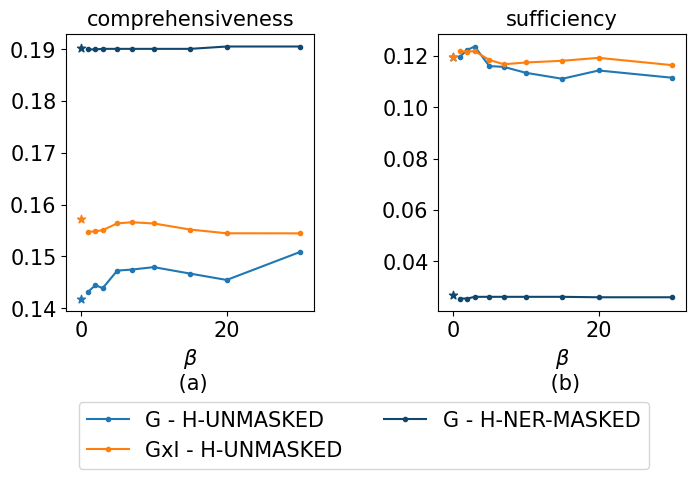

In [20]:
df_faith = pd.DataFrame(f_res).T
df_faith = df_faith[['compr2', 'suff2']]
df_faith.columns = ['comprehensiveness', 'sufficiency']
metrics_plot = ['comprehensiveness', 'sufficiency']



df_faith_xperc = df_faith.loc[(df_faith.index.str.contains('perc_40'))]

df_faith_ner = df_faith_xperc.loc[ (df_faith_xperc.index.str.contains('NER')==True)]


minv, maxv = -2, 32



expl_new_names = {'loo_': 'LOO', 'gradient_': 'G', 'gradientXinput_':'GxI'}
fontsize = 15

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c',  '#12476d']

fig, (axs) = plt.subplots(1, 2, figsize = (8, 3.6))

for masking in ['none', 'roberta']:       
    df_res2 = df_faith_ner.loc[(df_faith_ner.index.str.contains(masking)) ]
    sel1 = pm.loc[pm.index.str.contains(masking)]
    #fig, (axs) = plt.subplots(1, 4, figsize=(15.5,4))
    
    for e, explainer in enumerate(['gradient_', 'gradientXinput_']): #, 'loo_']):
        explainer_name = expl_new_names[explainer] + ' - ' + viz_masking[masking]
        df_sel = df_res2.loc[df_res2.index.str.contains(explainer)]
        sel2 = sel1.loc[sel1.index.str.contains(explainer)]

        d_target = df_faith_xperc.loc[(df_faith_xperc.index.str.contains(explainer))&(df_faith_xperc.index.str.contains(masking))&(df_faith_xperc.index.str.contains('NER')==False)] #*100
        unboosted_metrics = d_target.reset_index(drop=True).T.to_dict()[0]


        if df_sel.shape[0]!=0:
            #display(df_sel.style.highlight_max(color='blue'))
            for i, metric in enumerate(metrics_plot):
                
                x = [int(v.split('NER')[1].split('_')[0]) for v in df_sel[metric].index]
                y = df_sel[metric].values #*100

                if explainer=='gradient_' and masking=='roberta':
                    e = 3
                axs[i].plot(x, y, label =explainer_name, marker = '.', color=colors[e])
                axs[i].scatter(0, unboosted_metrics[metric], marker = '*', color=colors[e])
                axs[i].set_title(metric, fontsize = fontsize)
                i_str = string.ascii_lowercase[i]
                axs[i].set_xlabel(r"$\beta$" + f" \n ({i_str})", fontsize = fontsize)
                axs[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))
                axs[i].xaxis.set_tick_params(labelsize=fontsize)
                axs[i].yaxis.set_tick_params(labelsize=fontsize)
                axs[i].set_xlim(minv, maxv)
            
axs[0].legend(loc='upper center', bbox_to_anchor=(1.2, -0.29),
        fancybox=True,  ncol=2, fontsize = fontsize)
# fig.tight_layout()
plt.subplots_adjust( wspace=0.5, hspace=0.5)
fig.savefig(f'{output_dir}/beta_impact_faithfulness.pdf', bbox_inches="tight")
plt.show()

# All

[1, 2, 3, 5, 7, 10, 15, 20, 30]
[1, 2, 3, 5, 7, 10, 15, 20, 30]
[3, 5, 7, 10, 15, 20, 30]
[1, 2, 3, 5, 7, 10, 15, 20, 30]


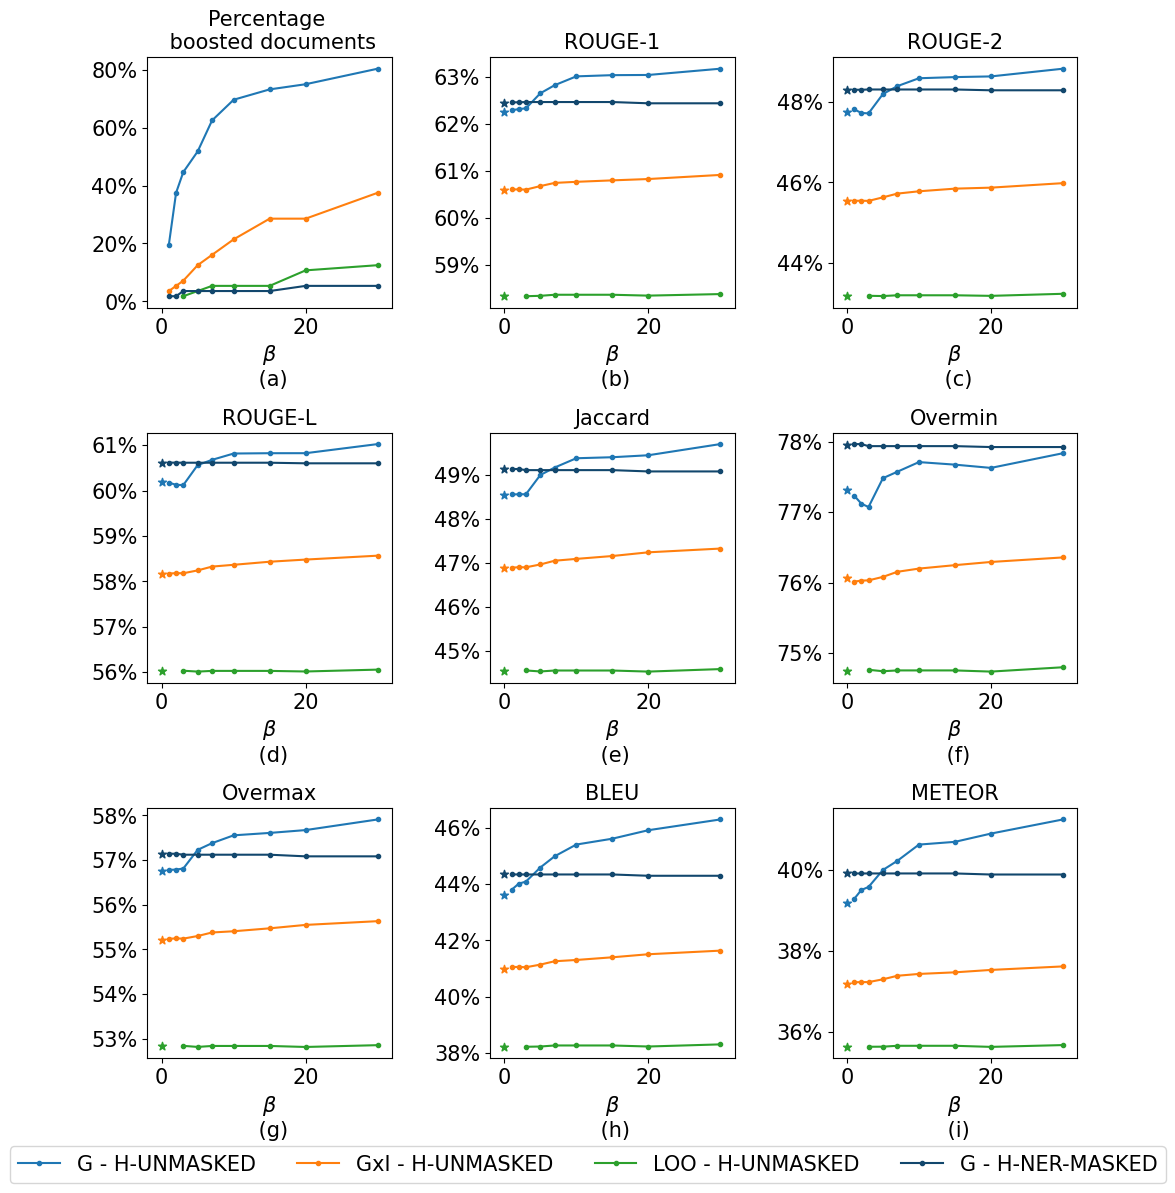

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter


import string
string.ascii_lowercase


df_res = pd.DataFrame(coll_res)
df_res =  df_res.rename(columns={'BLEU   ': 'BLEU', 'METEOR ': 'METEOR'})
df_res_xperc = df_res.loc[(df_res.index.str.contains('perc_40'))]
df_res_ner = df_res_xperc.loc[ (df_res_xperc.index.str.contains('NER')==True)]


pm = pd.DataFrame(percentages_mod).T*100
pm = pm[['perc_40']].dropna()

expl_new_names = {'loo_': 'LOO', 'gradient_': 'G', 'gradientXinput_':'GxI'}
fontsize = 15
minv, maxv = -2, 32

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c',  '#12476d']

metrics_plot = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Jaccard', 'Overmin', 'Overmax','BLEU', 'METEOR']
fig, (axs) = plt.subplots(3, 3, figsize = (12, 13))


for masking in ['none', 'roberta']:       
    df_res2 = df_res_ner.loc[(df_res_ner.index.str.contains(masking)) ]
    sel1 = pm.loc[pm.index.str.contains(masking)]
    #fig, (axs) = plt.subplots(1, 4, figsize=(15.5,4))

    
    
    for e, explainer in enumerate(['gradient_', 'gradientXinput_', 'loo_']):
        explainer_name = expl_new_names[explainer] + ' - ' + viz_masking[masking]
        df_sel = df_res2.loc[df_res2.index.str.contains(explainer)]
        sel2 = sel1.loc[sel1.index.str.contains(explainer)]

        d_target = df_res_xperc.loc[(df_res_xperc.index.str.contains(explainer))&(df_res_xperc.index.str.contains(masking))&(df_res_xperc.index.str.contains('NER')==False)]*100
        unboosted_metrics = d_target.reset_index(drop=True).T.to_dict()[0]


        if df_sel.shape[0]!=0:
            #display(df_sel.style.highlight_max(color='blue'))
            for i_metric, metric in enumerate(metrics_plot):
                i_metric = i_metric +1
                i, j = int(i_metric/3), i_metric%3
                x = [int(v.split('NER')[1].split('_')[0]) for v in df_sel[metric].index]
                y = df_sel[metric].values*100

                if explainer=='gradient_' and masking=='roberta':
                    e = 3
                axs[i][j].plot(x, y, label =explainer_name, marker = '.', color=colors[e])
                axs[i][j].scatter(0, unboosted_metrics[metric], marker = '*', color=colors[e])
                axs[i][j].set_title(metric, fontsize = fontsize)
                i_str = string.ascii_lowercase[i_metric]
                axs[i][j].set_xlabel(r"$\beta$" + f" \n ({i_str})", fontsize = fontsize)

                #axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f%'))
                axs[i][j].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
                axs[i][j].xaxis.set_tick_params(labelsize=fontsize)
                axs[i][j].yaxis.set_tick_params(labelsize=fontsize)
                axs[i][j].set_xlim(minv, maxv)

            x_perc = [int(v.split('NER')[1].split('_')[0]) for v in sel2['perc_40'].index]
            print(x_perc)
            y_perc = sel2['perc_40'].values
            i_str = string.ascii_lowercase[0]
            axs[0][0].plot(x_perc, y_perc, label = explainer_name, marker = '.', color=colors[e])
            axs[0][0].set_title('Percentage \n boosted documents', fontsize = fontsize)
            axs[0][0].set_xlabel(r"$\beta$"+ f" \n ({i_str})", fontsize = fontsize)
            axs[0][0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
            axs[0][0].xaxis.set_tick_params(labelsize=fontsize)
            axs[0][0].yaxis.set_tick_params(labelsize=fontsize)
            axs[0][0].set_xlim(minv, maxv)


axs[-1][1].legend(loc='upper center', bbox_to_anchor=(0.4, -0.31),
        fancybox=True,  ncol=5, fontsize = fontsize)
# fig.tight_layout()
plt.subplots_adjust( wspace=0.4, hspace=0.5)
fig.savefig(f'{output_dir}/beta_impact_all_metric_and_perc.pdf', bbox_inches="tight")
plt.show()

## Separate

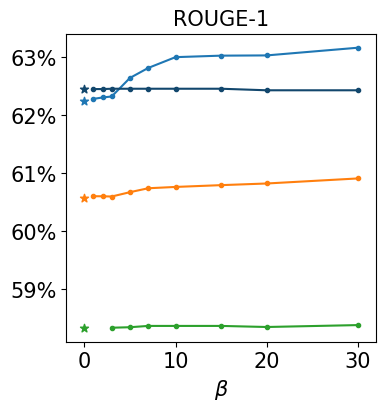

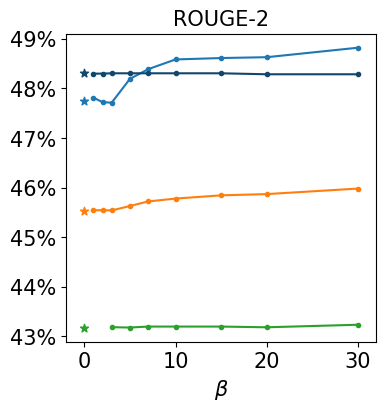

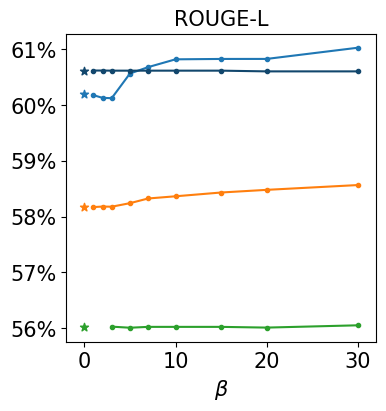

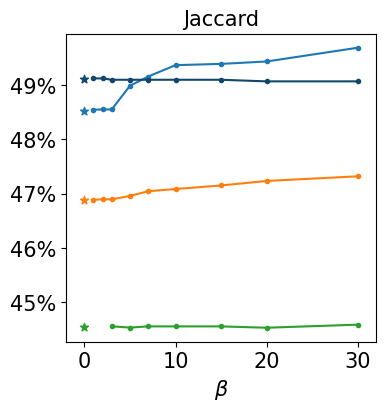

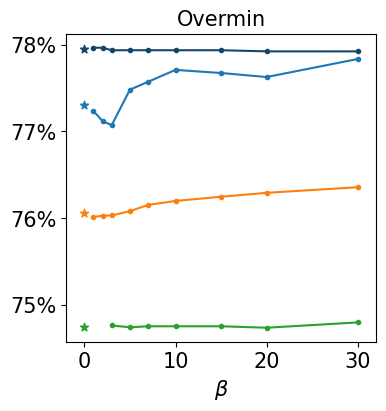

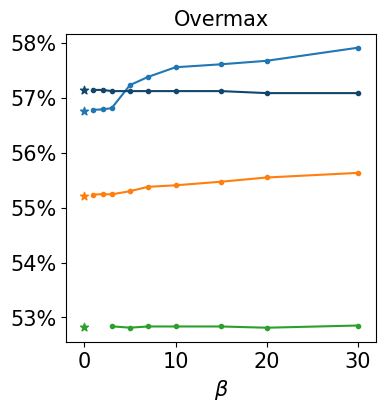

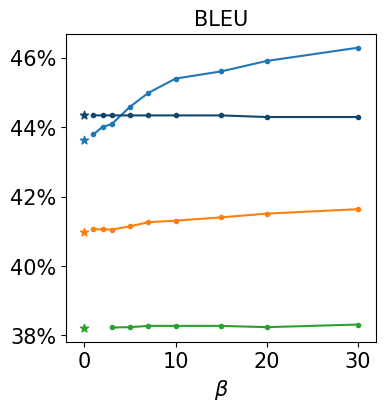

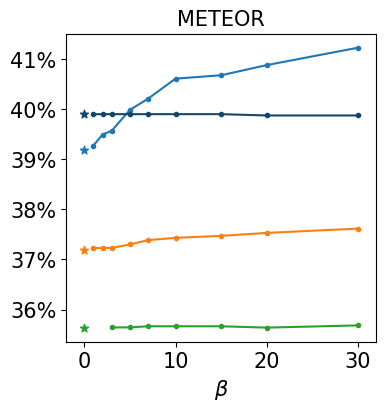

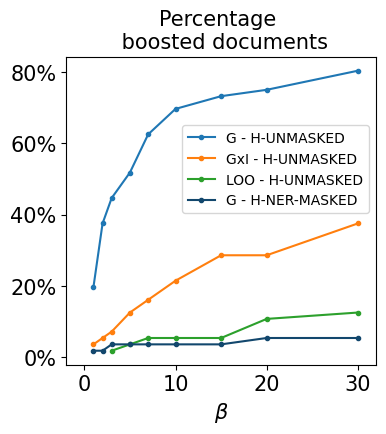

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

df_res = pd.DataFrame(coll_res)
df_res =  df_res.rename(columns={'BLEU   ': 'BLEU', 'METEOR ': 'METEOR'})
df_res_xperc = df_res.loc[(df_res.index.str.contains('perc_40'))]
df_res_ner = df_res_xperc.loc[ (df_res_xperc.index.str.contains('NER')==True)]


pm = pd.DataFrame(percentages_mod).T*100
pm = pm[['perc_40']].dropna()

expl_new_names = {'loo_': 'LOO', 'gradient_': 'G', 'gradientXinput_':'GxI'}
fontsize = 15
minv, maxv = -2, 32

metrics_plot = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Jaccard', 'Overmin', 'Overmax','BLEU', 'METEOR']


colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c',  '#12476d']
  
    

for i, metric in enumerate(metrics_plot):

         
    fig, ax = plt.subplots(1, 1, figsize=(4,4))

    for masking in ['none', 'roberta']:     
        df_res2 = df_res_ner.loc[(df_res_ner.index.str.contains(masking)) ]
        sel1 = pm.loc[pm.index.str.contains(masking)]
        
        for e, explainer in enumerate(['gradient_', 'gradientXinput_', 'loo_']):
            explainer_name = expl_new_names[explainer] + ' - ' + viz_masking[masking]
            df_sel = df_res2.loc[df_res2.index.str.contains(explainer)]
            sel2 = sel1.loc[sel1.index.str.contains(explainer)]

            d_target = df_res_xperc.loc[(df_res_xperc.index.str.contains(explainer))&(df_res_xperc.index.str.contains(masking))&(df_res_xperc.index.str.contains('NER')==False)]*100
            unboosted_metrics = d_target.reset_index(drop=True).T.to_dict()[0]


            if df_sel.shape[0]!=0:
            
                x = [int(v.split('NER')[1].split('_')[0]) for v in df_sel[metric].index]
                y = df_sel[metric].values*100

                if explainer=='gradient_' and masking=='roberta':
                    e = 3
                ax.plot(x, y, label =explainer_name, marker = '.', color=colors[e])
                ax.scatter(0, unboosted_metrics[metric], marker = '*', color=colors[e])
                ax.set_title(metric, fontsize = fontsize)
                ax.set_xlabel(r"$\beta$", fontsize = fontsize)

                #axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f%'))
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
                ax.xaxis.set_tick_params(labelsize=fontsize)
                ax.yaxis.set_tick_params(labelsize=fontsize)
                ax.set_xlim(minv, maxv)

    #ax.legend(loc='upper center', bbox_to_anchor=(0.99, -0.2), fancybox=True,  ncol=5, fontsize = fontsize)
    # fig.tight_layout()
    plt.subplots_adjust( wspace=0.27)
    fig.savefig(f'{output_dir_separate}/beta_impact_{metric}.pdf', bbox_inches="tight")
    plt.show()



fig, ax = plt.subplots(1, 1, figsize=(4,4))
for masking in ['none', 'roberta']:       
    sel1 = pm.loc[pm.index.str.contains(masking)]
    for e, explainer in enumerate(['gradient_', 'gradientXinput_', 'loo_']):
        explainer_name = expl_new_names[explainer] + ' - ' + viz_masking[masking]
        sel2 = sel1.loc[sel1.index.str.contains(explainer)]

        x_perc = [int(v.split('NER')[1].split('_')[0]) for v in sel2['perc_40'].index]

        y_perc = sel2['perc_40'].values
        if explainer=='gradient_' and masking=='roberta':
                    e = 3

        if len(y_perc)>0:
            ax.plot(x_perc, y_perc, label = explainer_name, marker = '.', color=colors[e])
            ax.set_title('Percentage \n boosted documents', fontsize = fontsize)
            ax.set_xlabel(r"$\beta$", fontsize = fontsize)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
            ax.xaxis.set_tick_params(labelsize=fontsize)
            ax.yaxis.set_tick_params(labelsize=fontsize)
            ax.set_xlim(minv, maxv)

fig.savefig(f'{output_dir_separate}/beta_impact_perc.pdf', bbox_inches="tight")
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
fig.savefig(f'{output_dir_separate}/beta_impact_perc_legend.pdf', bbox_inches="tight")
plt.show()

# Predictions

os.path.join(input_data_dir,f'predicted_prob_masking_{masking_type}.npy'

In [23]:
df_sentences = pd.read_csv(
        os.path.join(input_data_dir, "ILDC_for_explanation_sentences_masking.csv")
    )
df_sentences.drop(columns=["Unnamed: 0"], inplace=True)

In [24]:

for masking_type in ['none', 'roberta']:
    if os.path.isfile(os.path.join(input_data_dir,f'predicted_prob_masking_{masking_type}.npy')) == False:
            raise ValueError('Prediction not available')
        
    with open(os.path.join(input_data_dir,f'predicted_prob_masking_{masking_type}.npy'), 'rb') as f:
        output_probs = np.load(f)

    with open(os.path.join(input_data_dir,f'predicted_classes_masking_{masking_type}.npy'), 'rb') as f:
        predicted_classes = np.load(f)
        predicted_classes = list(predicted_classes)

    true_classes = df_sentences.loc[df_sentences['sent_index']==0].label.values

    true_classes = np.load(
        os.path.join(input_data_dir, f"labels_{masking_type}_explain.npy"),
        allow_pickle=True,
    )
    true_classes = [i.numpy()[0] for i in true_classes]

    print(masking_type)
    from sklearn.metrics import classification_report, confusion_matrix

    print(classification_report(true_classes, predicted_classes))
    print(confusion_matrix(true_classes, predicted_classes))

none
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        27
           1       0.76      0.66      0.70        29

    accuracy                           0.71        56
   macro avg       0.72      0.72      0.71        56
weighted avg       0.72      0.71      0.71        56

[[21  6]
 [10 19]]
roberta
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        27
           1       0.77      0.69      0.73        29

    accuracy                           0.73        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56

[[21  6]
 [ 9 20]]


In [25]:
import torch
from architecture.second_level_model import SecondLevelModel


for masking_type in ['none', 'roberta']:

    # Load embedding

    embd = np.load(
        os.path.join(input_data_dir, f"embeddings_{masking_type}_explain.npy"),
        allow_pickle=True,
    )

    # Model parameters
    attention_layers = 4
    mlp_layers = 2

    lr = "5e-05"

    model_dir = f'{str(Path.home())}/models/legal/CJP/'
    model_name = f"second_level_train_last_mask-{masking_type}_{attention_layers}_{mlp_layers}_{lr}"
    model_name_clean = model_name.replace("-", "_")

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embedding_size = torch.from_numpy(embd[0]).shape[1]
    model = SecondLevelModel(
        d_model=embedding_size,
        d_hid=embedding_size,
        nlayers=attention_layers,
        mlp_layers=mlp_layers,
    )
    t = torch.load(os.path.join(model_dir, model_name, "model.pt"))
    model.eval()
    model.load_state_dict(t)
    model.to(device)

    from code.second_level_dataset import LJPESecondLevelClassificationDataset
    from torch.utils.data import DataLoader

    strategy = "last"
    max_sentences = 256

    data_ds = LJPESecondLevelClassificationDataset(
        embd,
        np.array([1] * embd.shape[0]),
        strategy=strategy,
        max_sentences=max_sentences,
    )

    ds_dataloader = DataLoader(
        data_ds, batch_size=56, shuffle=False, num_workers=16, pin_memory=True
    )

    predicted_classes = []

    for batch in ds_dataloader:
        embeddings, attention_masks, labels = batch
        embeddings = embeddings.to(device)
        attention_masks = attention_masks.to(device)


        output = model(embeddings, attention_masks.transpose(1, 0))
        output_probs = torch.cat([1-output, output], dim=1).detach().cpu().numpy()
        predicted_classes.extend((output.squeeze(1)>0.5).int().cpu().detach().numpy())


        true_classes = np.load(
            os.path.join(input_data_dir, f"labels_{masking_type}_explain.npy"),
            allow_pickle=True,
        )
        true_classes = [i.numpy()[0] for i in true_classes]

        print(masking_type)
        from sklearn.metrics import classification_report, confusion_matrix

        print(classification_report(true_classes, predicted_classes))
        print(confusion_matrix(true_classes, predicted_classes))

Start Loading..
none
              precision    recall  f1-score   support

           0       0.68      0.78      0.72        27
           1       0.76      0.66      0.70        29

    accuracy                           0.71        56
   macro avg       0.72      0.72      0.71        56
weighted avg       0.72      0.71      0.71        56

[[21  6]
 [10 19]]
Start Loading..
roberta
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        27
           1       0.77      0.69      0.73        29

    accuracy                           0.73        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56

[[21  6]
 [ 9 20]]
